In [1]:
import csv
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score

In [2]:
def read_csv(filename):
    def parse_float(f):
        try:
            return float(f)
        except:
            return f
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        data = [[parse_float(f) for f in row] for row in reader]
    return header, data

header_int, data_int = read_csv('combined_results_internal.csv')
header_ext, data_ext = read_csv('combined_results_external.csv')

In [3]:
filenames = [row[0] for row in data_int]
filename_index = {row[0]: row for row in data_int}

bootstrap_samples = [np.random.choice(filenames, size=len(filenames), replace=True) for _ in range(2000)]
bootstrap_rows = [[filename_index[f] for f in sample] for sample in bootstrap_samples]

In [4]:
filenames_ext = [row[0] for row in data_ext]
filename_index_ext = {row[0]: row for row in data_ext}

bootstrap_samples_ext = [np.random.choice(filenames_ext, size=len(filenames_ext), replace=True) for _ in range(2000)]
bootstrap_rows_ext = [[filename_index_ext[f] for f in sample] for sample in bootstrap_samples_ext]

In [5]:
def get_auc(rows, i_r, i_o, class_name):
    ref = [int(row[i_r] == class_name) for row in rows]
    obs = [row[i_o] for row in rows]
    return roc_auc_score(ref, obs)

def auc_scores(reference, class_name, header, rows, bootstrap_rows):
    i_r = header.index(reference)
    result = []
    for obs in ('bespoke_{}'.format(class_name), 'autoML_{}'.format(class_name)):
        i_o = header.index(obs)
        score = get_auc(rows, i_r, i_o, class_name)
        bootstrapped = [get_auc(rows, i_r, i_o, class_name) for rows in bootstrap_rows]
        result.append((score, 
                       np.quantile(bootstrapped, 0.025), 
                       np.quantile(bootstrapped, 0.975))
                     )
    return result

## AUC Internal

In [8]:
class_names = 'normal', 'pre-plus','plus'

graders_x_axis_ordered = ('majority', 'bespoke', 'autoML', 
                          'GA', 'HP', 'RH', 'AMH', 'MA', 'JR', 'JT', 'CH', 'CK', 'SB'
                         )
labels = ('Majority', 'Bespoke', 'CFDL',
          'CR1', 'CR2', 'CR3', 'CR4', 
          'JR1', 'AHP1', 
          'JR2', 'JR3', 'JR4', 'JR5'
         )
labels_map = {k:v for k, v in zip(graders_x_axis_ordered, labels)}
labels_map

{'majority': 'Majority',
 'bespoke': 'Bespoke',
 'autoML': 'CFDL',
 'GA': 'CR1',
 'HP': 'CR2',
 'RH': 'CR3',
 'AMH': 'CR4',
 'MA': 'JR1',
 'JR': 'AHP1',
 'JT': 'JR2',
 'CH': 'JR3',
 'CK': 'JR4',
 'SB': 'JR5'}

In [9]:
graders = (*graders_x_axis_ordered[3:], 'majority')
np.random.seed(0)
for class_name in 'normal', 'pre-plus', 'plus':
    print(class_name)
    all_aucs = [auc_scores(grader, class_name, header_int, data_int, bootstrap_rows) for grader in graders]
    for grader, (bespoke, autoML) in zip(graders, all_aucs):
        print('{:12s} {:.3f} ({:.3f}-{:.3f}) {:.3f} ({:.3f}-{:.3f})'.format(labels_map[grader], *bespoke, *autoML))
        
    bespoke_aucs = [bespoke[0] for bespoke, autoML in all_aucs[:-1]] # leave out majority
    autoML_aucs = [autoML[0] for bespoke, autoML in all_aucs[:-1]] # leave out majority
    print('avg bespoke: {:.3f} ± {:.3f}'.format(np.mean(bespoke_aucs), np.std(bespoke_aucs)))
    print('avg autoML:  {:.3f} ± {:.3f}'.format(np.mean(autoML_aucs), np.std(autoML_aucs)))
    print()

normal
CR1          0.980 (0.961-0.994) 0.984 (0.970-0.994)
CR2          0.982 (0.965-0.994) 0.986 (0.973-0.994)
CR3          0.972 (0.948-0.989) 0.975 (0.956-0.990)
CR4          0.993 (0.984-0.998) 0.993 (0.984-0.998)
JR1          0.993 (0.985-0.999) 0.989 (0.978-0.998)
AHP1         0.954 (0.918-0.980) 0.970 (0.939-0.990)
JR2          0.989 (0.977-0.997) 0.985 (0.971-0.994)
JR3          0.979 (0.959-0.993) 0.976 (0.949-0.995)
JR4          0.955 (0.926-0.979) 0.949 (0.917-0.974)
JR5          0.936 (0.901-0.964) 0.935 (0.901-0.962)
Majority     0.992 (0.981-0.998) 0.992 (0.983-0.998)
avg bespoke: 0.973 ± 0.018
avg autoML:  0.974 ± 0.018

pre-plus
CR1          0.914 (0.868-0.954) 0.933 (0.894-0.966)
CR2          0.883 (0.830-0.927) 0.927 (0.888-0.959)
CR3          0.880 (0.824-0.932) 0.850 (0.793-0.901)
CR4          0.882 (0.833-0.928) 0.885 (0.819-0.941)
JR1          0.893 (0.845-0.936) 0.907 (0.848-0.953)
AHP1         0.822 (0.753-0.882) 0.860 (0.786-0.919)
JR2          0.893 (0.845-0.

## AUC External

In [10]:
for class_name in 'normal', 'pre-plus', 'plus':
    print(class_name)
    bespoke, autoML = auc_scores('label', class_name, header_ext, data_ext, bootstrap_rows_ext)
    print('{:.3f} ({:.3f}-{:.3f}) {:.3f} ({:.3f}-{:.3f})'.format( *bespoke, *autoML))
    print()

normal
1.000 (0.998-1.000) 0.995 (0.982-1.000)

pre-plus
0.943 (0.892-0.983) 0.808 (0.691-0.910)

plus
0.976 (0.936-1.000) 0.989 (0.969-1.000)



In [11]:
def get_roc(rows, reference, observer, class_name, invert):
    i_r = header_int.index(reference)
    i_o = header_int.index(observer)
    ref = [int(row[i_r] == class_name) for row in rows]
    obs = [row[i_o] for row in rows]
    if invert:
        return roc_curve([1 - x for x in ref], [1 - x for x in obs])
    else:
        return roc_curve(ref, obs)

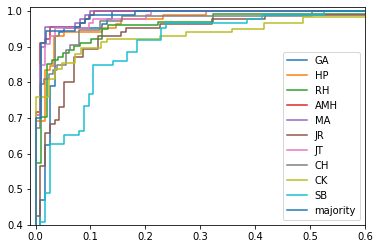

In [12]:
class_name = 'normal'
observer = 'bespoke_{}'.format(class_name)
invert = True
for grader in graders:
    fpr, tpr, threshold = get_roc(data_int, grader, observer, class_name, invert)
    plt.plot(fpr, tpr, label=grader)
plt.xlim(-0.01, 0.6)
plt.ylim(0.4, 1.01)
plt.legend()

In [13]:
def se_sp(ref, obs):
    tp = np.sum((ref == 1) & (obs == 1))
    tn = np.sum((ref == 0) & (obs == 0))
    fp = np.sum((ref == 0) & (obs == 1))
    fn = np.sum((ref == 1) & (obs == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

### ROC per class models vs majority

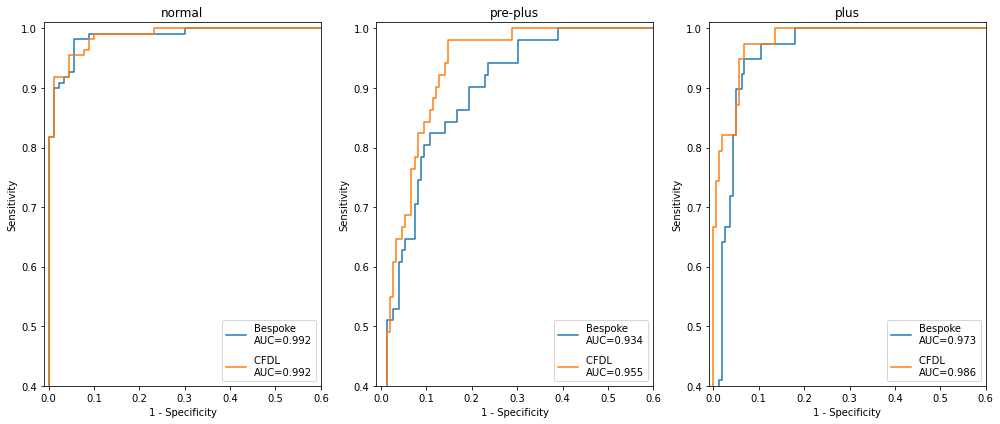

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

for ax, class_name in zip(axes, class_names):
    ref = [int(row[header_int.index('majority')] == class_name) for row in data_int]
    for m in 'bespoke', 'autoML':
        model = np.array([row[header_int.index('{}_{}'.format(m, class_name))]
                          for row in data_int])
        fpr, tpr, thresholds = roc_curve(ref, model)    
        auc = roc_auc_score(ref, model)
        ax.plot(fpr, tpr, label = '{:8s} \nAUC={:.3f}'.format(labels_map[m], auc))
        
    ax.set_xlim(-0.01, 0.6)
    ax.set_ylim(0.4, 1.01)
    ax.set_title(class_name)
    ax.legend(loc='lower right', labelspacing=1.0)
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')

plt.tight_layout()
plt.savefig('Figure3.tiff')

In [15]:
def plot_all_ROC(class_name = 'normal', invert = True):

    fig, axes = plt.subplots(2, 5, figsize=(24, 12))

    graders = graders_x_axis_ordered[3:]
    for i, grader in enumerate(graders):
        ax = axes[i//5][i%5]

        grader_scores = {
            grader: np.array([int(row[header_int.index(grader)] == class_name) 
                     for row in data_int])
            for grader in graders
        }    
        if invert:
            grader_scores = {g: 1 - ref for g, ref in grader_scores.items()}

        ref = grader_scores[grader]    

        pts = np.array([se_sp(ref, grader_scores[observer]) 
                        for observer in graders
                        if observer != grader]
                      )
        obs_labels = [observer for observer in graders if observer != grader]
        for obs, (se, sp) in zip(obs_labels, pts):
            ax.scatter(1 - sp, se, label=labels_map[obs])

        for m in 'bespoke', 'autoML':
            model = np.array([row[header_int.index('{}_{}'.format(m, class_name))]
                              for row in data_int])
            if invert:
                model = 1 - model

            fpr, tpr, thresholds = roc_curve(ref, model)    
            auc = roc_auc_score(ref, model)
            ax.plot(fpr, tpr, label = '{:8s} \nAUC={:.3f}'.format(labels_map[m], auc))
            #ax.plot(fpr, tpr, label = '{:8s}'.format(labels_map[m]))

        ax.set_xlim(-0.01, 0.6)
        ax.set_ylim(0.4, 1.01)
        ax.set_title(labels_map[grader])
        ax.legend(loc='lower right', labelspacing=1.0)
        ax.set_xlabel('1 - Specificity')
        ax.set_ylabel('Sensitivity')

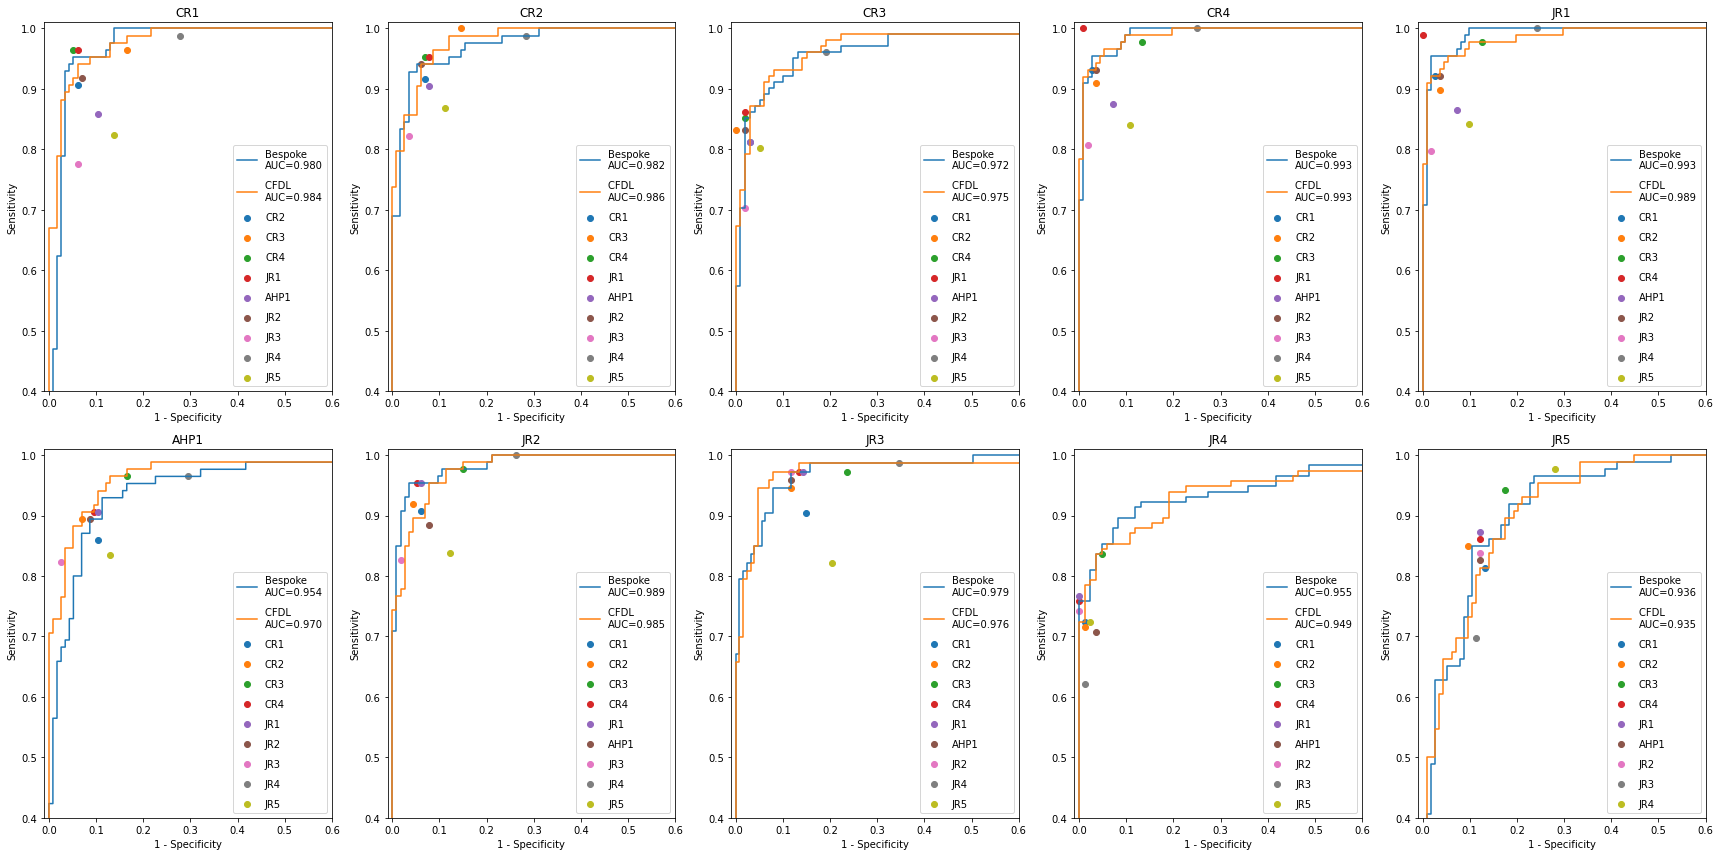

In [47]:
plot_all_ROC('normal', invert=True)
plt.tight_layout()
plt.savefig('Figure4.tiff')

normal


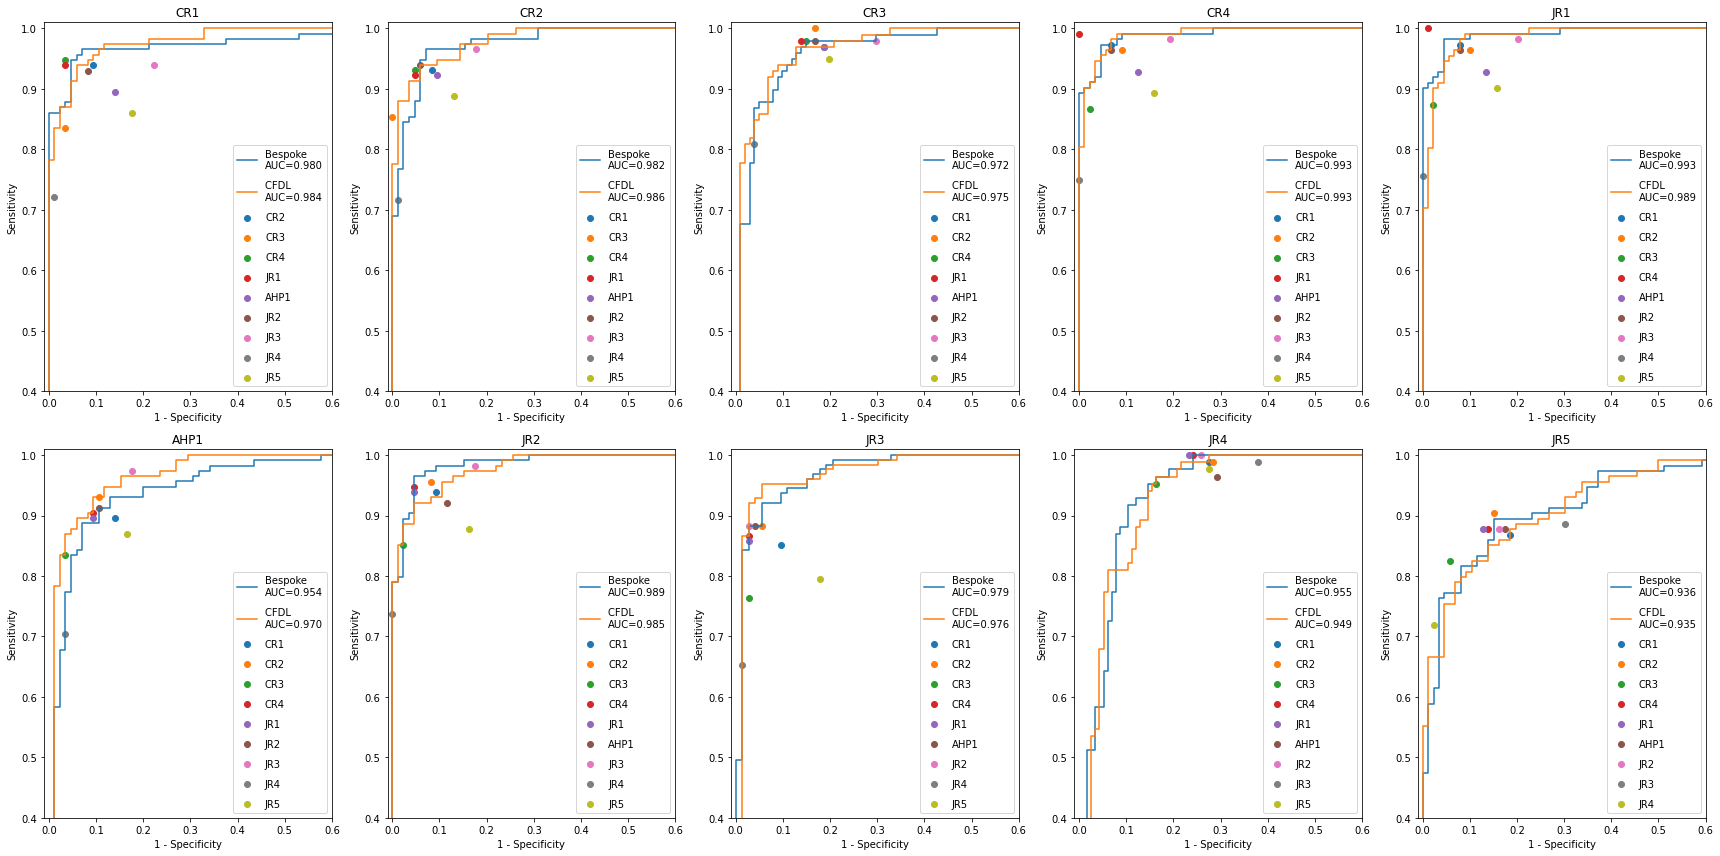

pre-plus


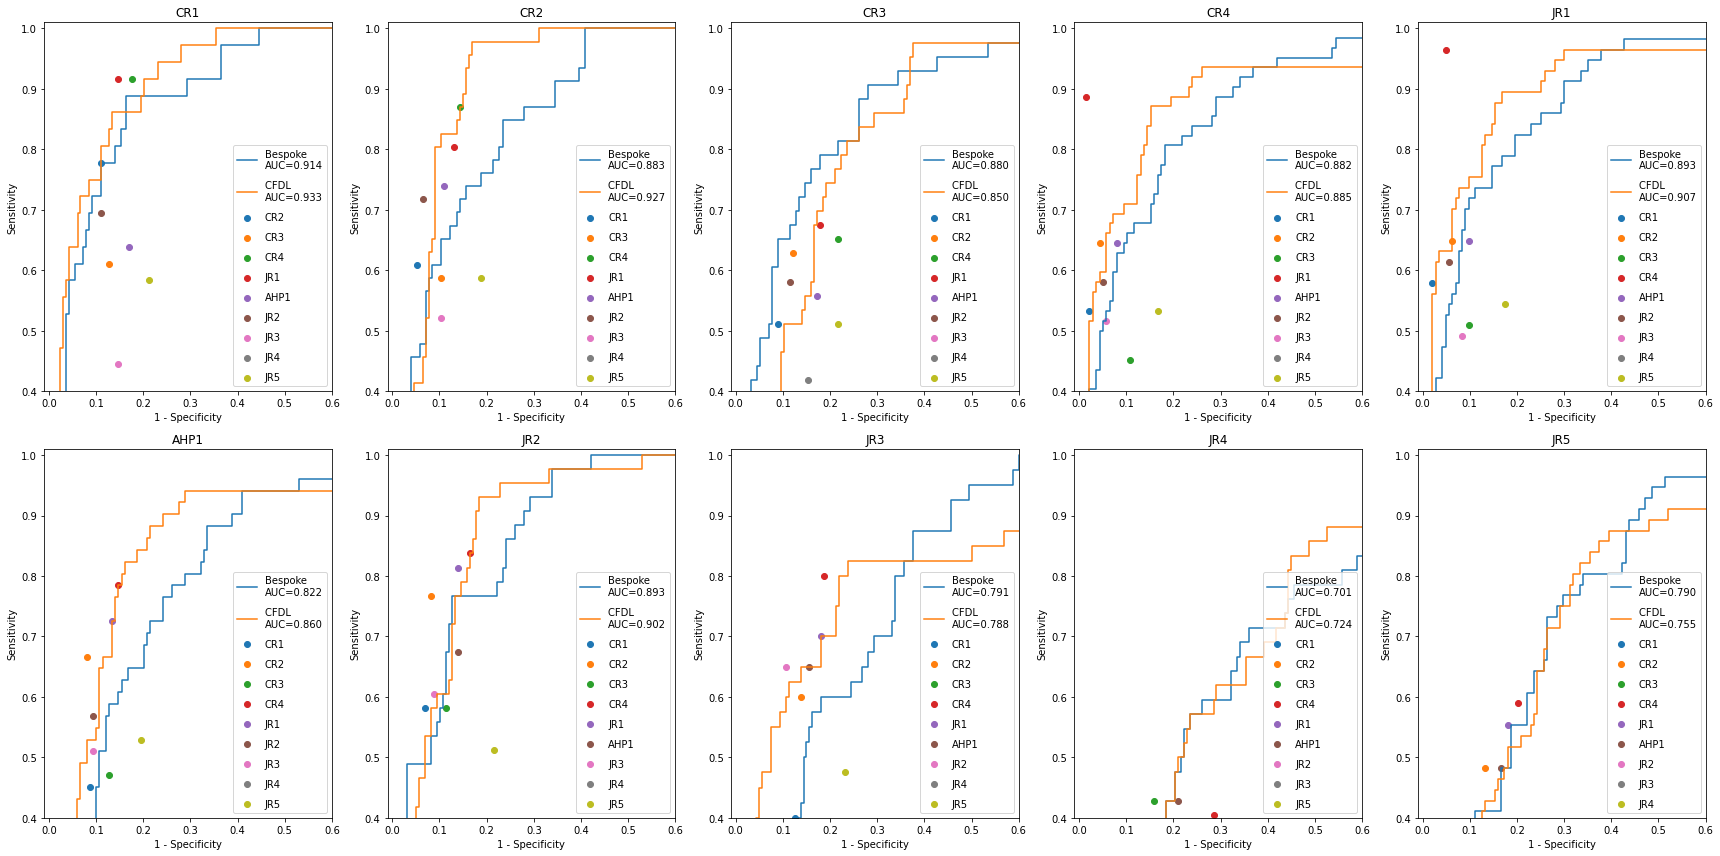

plus


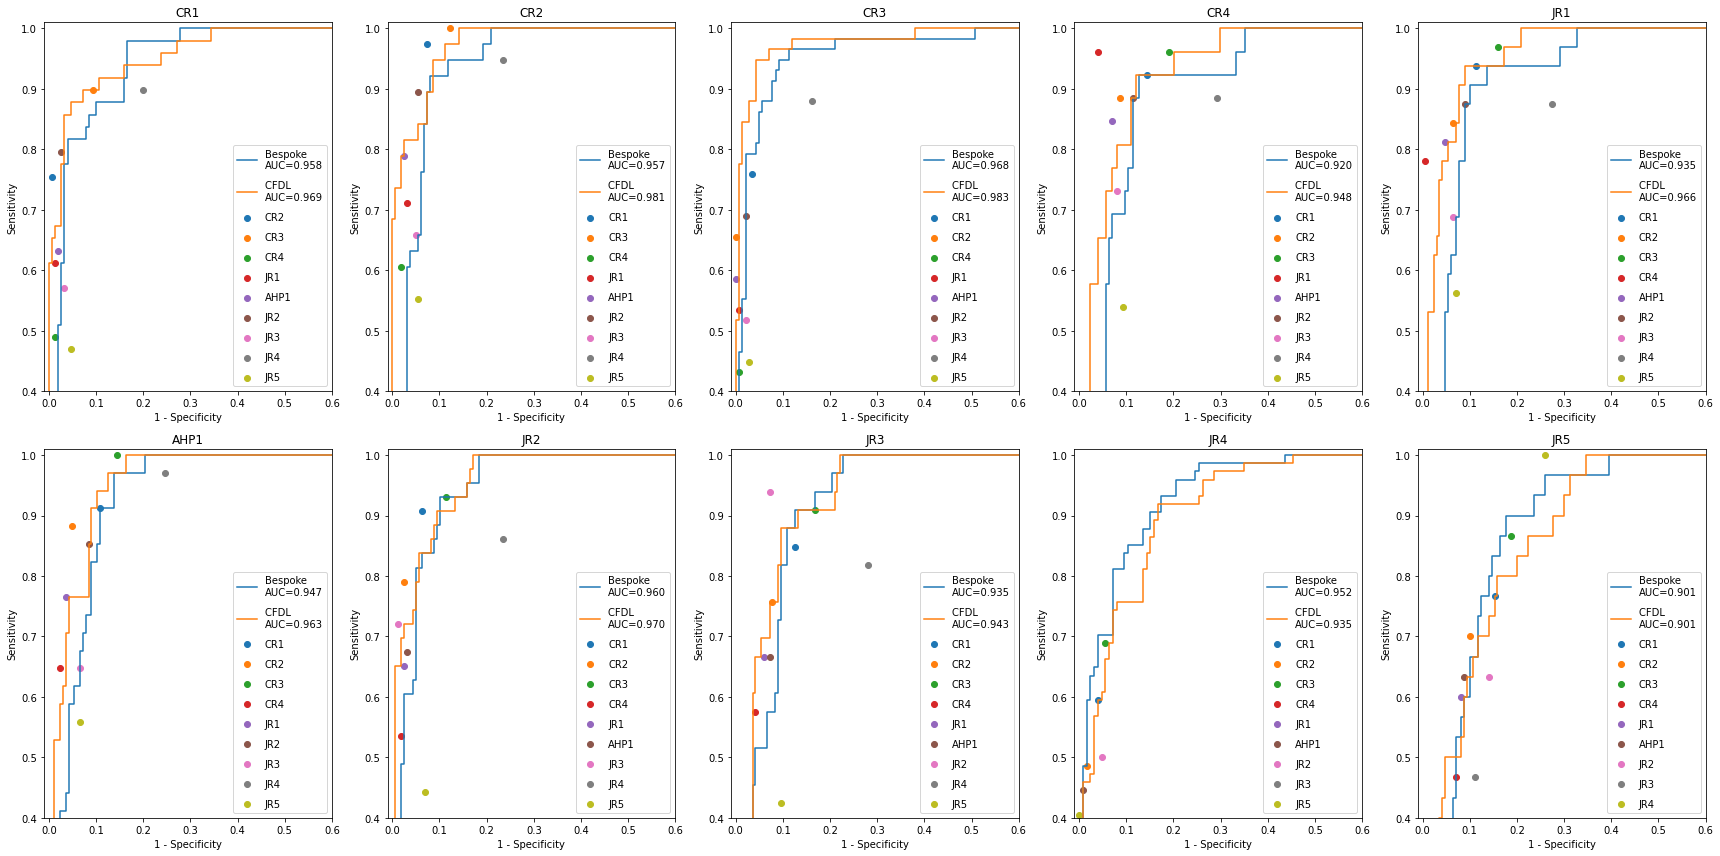

In [46]:
for class_name in class_names:
    print(class_name)
    plot_all_ROC(class_name, invert=False)
    plt.tight_layout()
    plt.savefig('SupplementalFigure_{}.tiff'.format(class_name))
    plt.show()

In [18]:
def plot_confusion(keys, labels, matrix):
    n, n = matrix.shape
    fig = plt.figure(figsize=(15, 12))
    plt.clf()
    ax = fig.add_subplot(111)
    r = ax.imshow(matrix, clim=[0,1], cmap='magma')
    for x in range(n):
        for y in range(n):
            ax.annotate('{:0.2f}'.format(matrix[x][y]), xy=(y, x), 
                        fontsize=12,
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.set_xticks(range(0, n))
    ax.xaxis.tick_top()
    ax.set_yticks(range(n-1, -1, -1))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels[::-1])
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    cb = fig.colorbar(r)

In [19]:

kappa_matrix = np.array([[cohen_kappa_score(
    [row[header_int.index(r)] for row in data_int],
    [row[header_int.index(o)] for row in data_int],
    weights='quadratic'
)
  for o in graders_x_axis_ordered
  ]
 for r in graders_x_axis_ordered
])

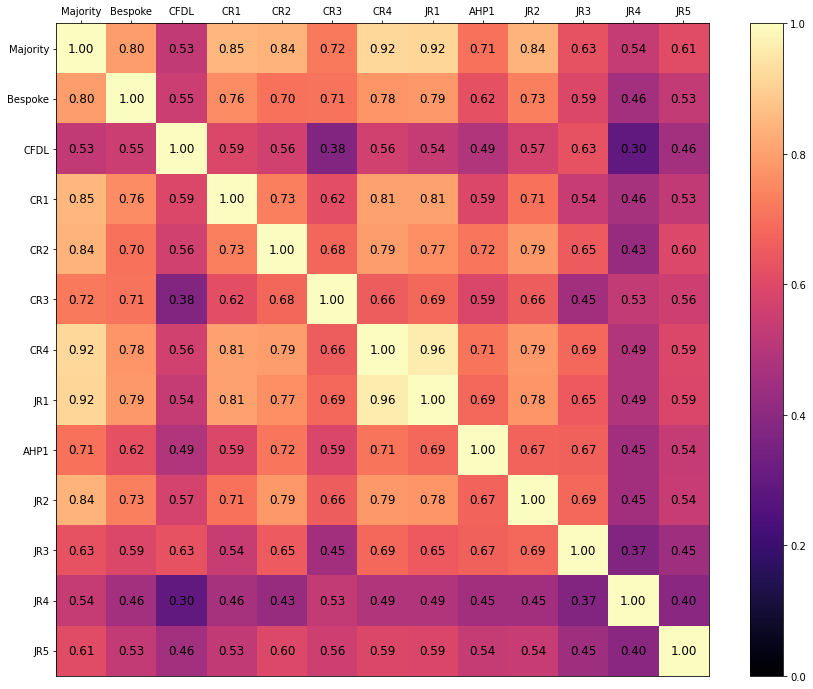

In [45]:
plot_confusion(graders_x_axis_ordered, labels, kappa_matrix)
#plt.tight_layout()
plt.savefig('Figure2.tiff')

In [21]:
def get_row(key):
    i = header_int.index(key)
    return np.array([row[i] for row in data_int])

In [22]:
score_index = {
    'normal': 0,
    'pre-plus': 0.5,
    'plus': 1
}

In [23]:
models_disagree = (get_row('autoML') != get_row('majority')) | (get_row('bespoke') != get_row('majority'))

In [34]:
np.array(graders_x_axis_ordered)[np.array([
    [score_index[x] for x in get_row(grader)]
    for grader in graders_x_axis_ordered
]).mean(axis=1).argsort()]
    

array(['CH', 'AMH', 'SB', 'JR', 'MA', 'autoML', 'HP', 'majority', 'JT',
       'GA', 'bespoke', 'RH', 'CK'], dtype='<U8')

In [37]:
graders_sensitivity_ordered = 'majority', 'bespoke', 'autoML', 'CH', 'AMH', 'SB', 'JR', 'MA', 'HP', 'JT', 'GA',  'RH', 'CK'

In [38]:
matrix = np.array([
    *[[score_index[x] for x in get_row(grader)]
      for grader in graders_sensitivity_ordered
     ],
#    1 - get_row('bespoke_normal'),
#    1 - get_row('autoML_normal'),
 
]).T

In [39]:
order = matrix[models_disagree, :-2].mean(axis=1).argsort()

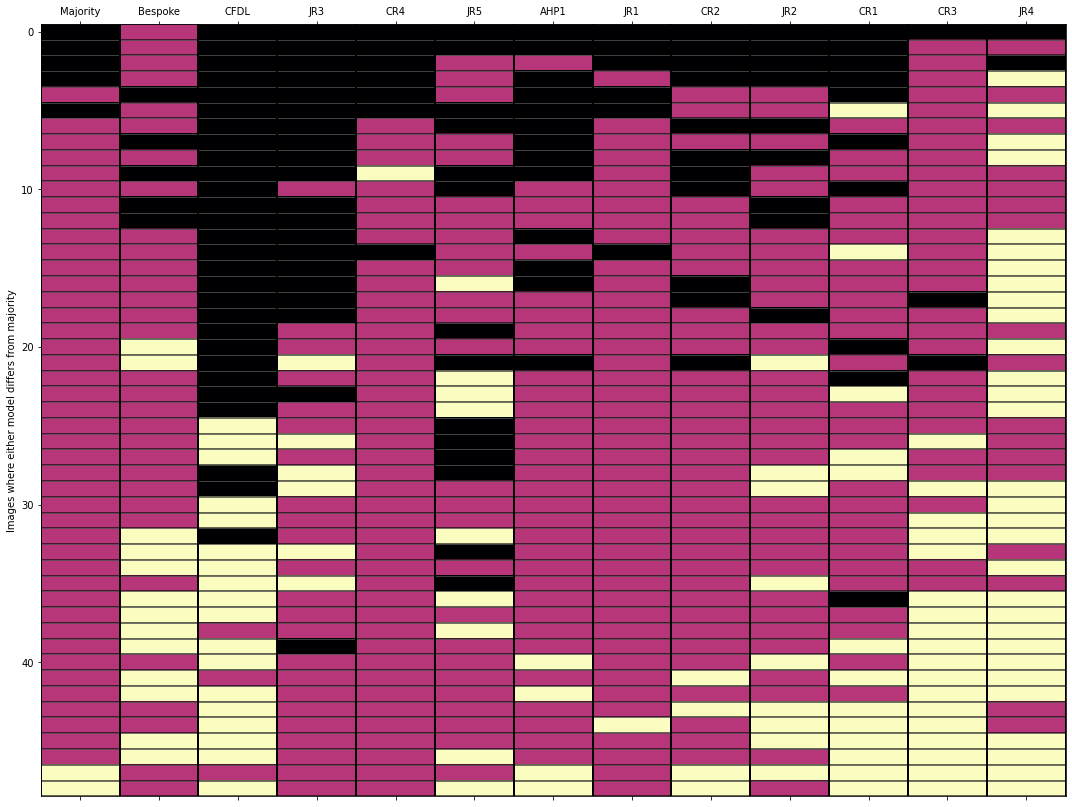

In [43]:
fig = plt.figure(figsize=(15, 12))
ax = fig.gca()
ax.matshow(matrix[models_disagree][order], aspect = 0.2, interpolation='none', cmap='magma') 
#labels = (*graders_x_axis_ordered, 'bespoke', 'autoML')


ax.set_xticks(np.arange(0, len(graders_sensitivity_ordered)))
ax.set_xticklabels(labels_map[grader] for grader in graders_sensitivity_ordered)

    
for i in range(len(order)+1):
    plt.axhline(i-0.5, c='k', linewidth=2, alpha=0.6)
for i in range(len(order)+1):
    plt.axhline(i-0.5, c='gray', linewidth=0.5, alpha=1)

for i in range(len(labels)+1):
    plt.axvline(i-0.5, c='k', linewidth=2)    
    
plt.ylabel('Images where either model differs from majority')
plt.tight_layout()
plt.savefig('Figure5.tiff')
plt.show()

In [25]:
np.sum(get_row('autoML') == 'pre-plus')

12

In [26]:
np.sum(get_row('bespoke') == 'pre-plus')

40

In [27]:
np.sum(get_row('majority') == 'pre-plus')

51